# Определение возраста покупателей

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

### Общие сведения о датасете

In [2]:
data_age = pd.read_csv('/datasets/faces/labels.csv')
data_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [3]:
data_age.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [4]:
data_age.head(5)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


### Распределение возраста в выборке

<AxesSubplot:>

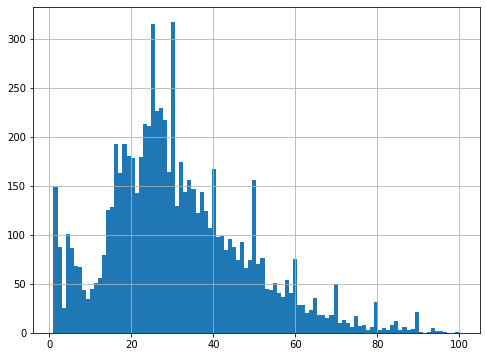

In [5]:
data_age['real_age'].hist(bins=100, figsize=(8, 6))

- на гистограмме видно, что люди разных возрастов представлены разными количестовм фото, соответсвенно для каждой возрастной категории будет разный размер обучающец выбоки и следовательно точность прогноза.

In [6]:
def category(age):
    if 0 < age <= 10:
        return 'дети'
    elif 10 < age <= 14:
        return 'подростки'
    elif 14 < age <= 20:
        return 'старшеклассники'
    elif 20 < age <= 30:
        return 'студенты'
    elif 30 < age <= 45:
        return 'зрелые'
    elif 45 < age <= 60:
        return 'взрослые'
    else:
        return 'старики'

<AxesSubplot:xlabel='category'>

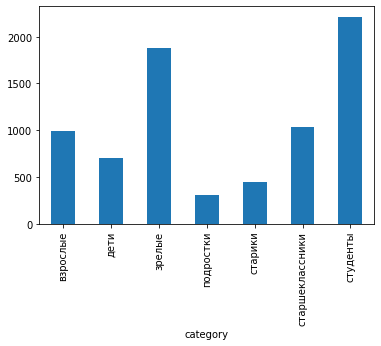

In [7]:
data_age['category'] = data_age['real_age'].apply(category)
data_age.groupby('category')['real_age'].count().plot(kind='bar')

- при разбиении выборки на условные категории, становиться очевиднее какие группы возрастов будут распознаваться моделью точнее наиболее вероятно (студенты, зрелые), а какие менее вероятно (подростки, старики)

### Вывод фото

Found 7591 images belonging to 1 classes.


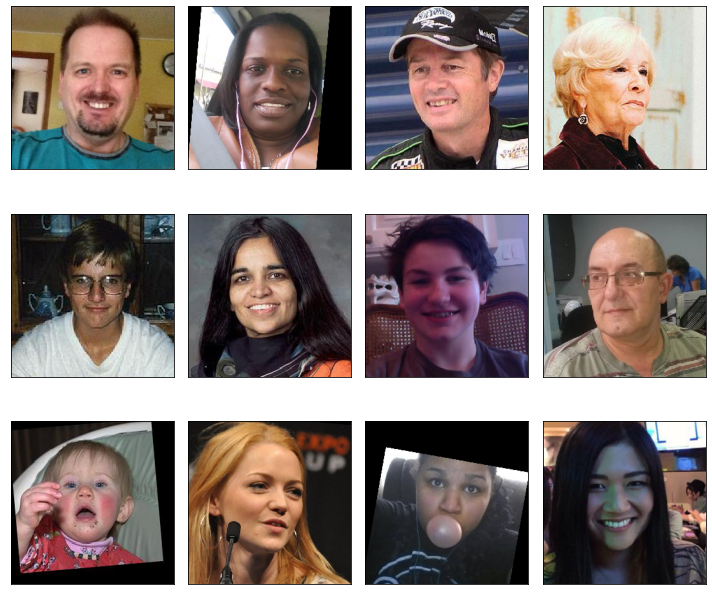

In [8]:
datagen = ImageDataGenerator(rescale=1/255.)

datagen_flow = datagen.flow_from_directory('/datasets/faces/',
    batch_size=12, 
    seed=12345)

features, target = next(datagen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод

- Существует неоднородное распределение фотографий по взрастам в датасете. Наиболее многочисленные в возрасте от 20 до 40 лет. Что отразиться на точности предсказания модели для разных возрастных групп.


- В датасете фото разного размера, угла поворота, разной яркости и цветовой гаммы. Фон не обрезан. Это наоборот должно дать модели большую вариативность при построении связей в слоях для повышения точности прогноза.

## Обучение модели

### Код модели

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd

def load_train(path):
  datagen = ImageDataGenerator(rescale=1./255,
                               horizontal_flip=True,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               validation_split=0.25)
  labels = pd.read_csv(path +'labels.csv')
  train_datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path + 'final_files/',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    x_col='file_name',
    y_col='real_age',
    subset='training',
    seed=12345
    )
  return train_datagen_flow

def load_test(path):
  datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.25)
  labels = pd.read_csv(path +'labels.csv')
  test_datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path + 'final_files/',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    x_col='file_name',
    y_col='real_age',
    subset='validation', 
    seed=12345
    )
  
  return test_datagen_flow

def create_model(input_shape):
  optimizer = Adam(lr=0.001)
  backbone = ResNet50(input_shape=input_shape,
                      weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                      include_top=False)

  model = Sequential()
  model.add(backbone)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(1, activation='relu'))

  model.compile(
    optimizer = optimizer,
    loss='mse',
    metrics=['mae']
    )
   
  return model

def train_model(model, train_data, test_data, batch_size=None, epochs=40,
                steps_per_epoch=None, validation_steps=None):
  
  if steps_per_epoch is None:
    steps_per_epoch = len(train_data)
  if validation_steps is None:
    validation_steps = len(test_data)

  model.fit(
    train_data,
    validation_data=test_data,
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=2
  )

  return model

```

### Результаты обучения

```
2022-07-07 16:31:53.359967: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-07-07 16:31:53.361623: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/40
356/356 - 98s - loss: 267.0219 - mae: 12.5631 - val_loss: 371.7345 - val_mae: 16.2161
Epoch 2/40
356/356 - 91s - loss: 217.3800 - mae: 11.4730 - val_loss: 318.7518 - val_mae: 14.7486
Epoch 3/40
356/356 - 90s - loss: 198.7141 - mae: 10.8627 - val_loss: 873.7598 - val_mae: 25.2883
Epoch 4/40
356/356 - 90s - loss: 179.9230 - mae: 10.3755 - val_loss: 168.0945 - val_mae: 10.0209
Epoch 5/40
356/356 - 91s - loss: 171.5876 - mae: 10.0895 - val_loss: 182.6327 - val_mae: 10.8232
Epoch 6/40
356/356 - 90s - loss: 160.0700 - mae: 9.7833 - val_loss: 244.4052 - val_mae: 11.8899
Epoch 7/40
356/356 - 90s - loss: 155.6879 - mae: 9.5705 - val_loss: 191.9529 - val_mae: 10.2699
Epoch 8/40
356/356 - 90s - loss: 148.7736 - mae: 9.3414 - val_loss: 148.3408 - val_mae: 9.4822
Epoch 9/40
356/356 - 89s - loss: 144.0686 - mae: 9.1993 - val_loss: 211.5216 - val_mae: 10.9675
Epoch 10/40
356/356 - 90s - loss: 138.5226 - mae: 9.0531 - val_loss: 192.4198 - val_mae: 10.2963
Epoch 11/40
356/356 - 90s - loss: 131.1247 - mae: 8.8070 - val_loss: 212.3342 - val_mae: 11.6549
Epoch 12/40
356/356 - 90s - loss: 127.5200 - mae: 8.6211 - val_loss: 140.9877 - val_mae: 9.2764
Epoch 13/40
356/356 - 90s - loss: 125.3202 - mae: 8.5603 - val_loss: 194.0645 - val_mae: 11.1073
Epoch 14/40
356/356 - 89s - loss: 120.3588 - mae: 8.4543 - val_loss: 280.9338 - val_mae: 13.3531
Epoch 15/40
356/356 - 90s - loss: 117.8785 - mae: 8.3049 - val_loss: 143.4697 - val_mae: 8.9942
Epoch 16/40
356/356 - 90s - loss: 117.0858 - mae: 8.2583 - val_loss: 144.9340 - val_mae: 9.0267
Epoch 17/40
356/356 - 90s - loss: 109.7669 - mae: 8.0183 - val_loss: 136.8607 - val_mae: 9.1461
Epoch 18/40
356/356 - 89s - loss: 105.0454 - mae: 7.8458 - val_loss: 120.0032 - val_mae: 8.3787
Epoch 19/40
356/356 - 90s - loss: 99.3053 - mae: 7.5975 - val_loss: 136.4468 - val_mae: 9.1463
Epoch 20/40
356/356 - 89s - loss: 99.1364 - mae: 7.5909 - val_loss: 154.6821 - val_mae: 9.0668
Epoch 21/40
356/356 - 90s - loss: 97.6829 - mae: 7.5497 - val_loss: 116.8074 - val_mae: 8.4974
Epoch 22/40
356/356 - 90s - loss: 93.5685 - mae: 7.3960 - val_loss: 113.5138 - val_mae: 8.0757
Epoch 23/40
356/356 - 90s - loss: 91.0647 - mae: 7.2926 - val_loss: 264.0613 - val_mae: 11.6307
Epoch 24/40
356/356 - 90s - loss: 85.8269 - mae: 7.0400 - val_loss: 147.0043 - val_mae: 8.6850
Epoch 25/40
356/356 - 90s - loss: 86.3720 - mae: 7.0884 - val_loss: 141.7393 - val_mae: 8.7151
Epoch 26/40
356/356 - 90s - loss: 81.5485 - mae: 6.9144 - val_loss: 146.8173 - val_mae: 9.1011
Epoch 27/40
356/356 - 90s - loss: 78.0915 - mae: 6.7575 - val_loss: 129.7030 - val_mae: 8.5325
Epoch 28/40
356/356 - 90s - loss: 78.0666 - mae: 6.7440 - val_loss: 272.7779 - val_mae: 11.8281
Epoch 29/40
356/356 - 90s - loss: 76.6382 - mae: 6.7225 - val_loss: 123.4223 - val_mae: 8.7239
Epoch 30/40
356/356 - 90s - loss: 72.3097 - mae: 6.5543 - val_loss: 103.2717 - val_mae: 7.5158
Epoch 31/40
356/356 - 89s - loss: 66.9993 - mae: 6.3209 - val_loss: 90.3335 - val_mae: 7.3328
Epoch 32/40
356/356 - 90s - loss: 71.1717 - mae: 6.4542 - val_loss: 210.3011 - val_mae: 10.6775
Epoch 33/40
356/356 - 89s - loss: 65.6105 - mae: 6.2125 - val_loss: 121.9475 - val_mae: 8.6796
Epoch 34/40
356/356 - 90s - loss: 65.5880 - mae: 6.2142 - val_loss: 281.0111 - val_mae: 12.7055
Epoch 35/40
356/356 - 90s - loss: 62.8095 - mae: 6.0724 - val_loss: 108.2193 - val_mae: 7.7351
Epoch 36/40
356/356 - 89s - loss: 62.3768 - mae: 6.0315 - val_loss: 277.3137 - val_mae: 13.2250
Epoch 37/40
356/356 - 89s - loss: 57.0759 - mae: 5.8119 - val_loss: 117.6798 - val_mae: 8.1404
Epoch 38/40
356/356 - 89s - loss: 57.3388 - mae: 5.8170 - val_loss: 119.0917 - val_mae: 8.3512
Epoch 39/40
356/356 - 90s - loss: 56.9863 - mae: 5.8010 - val_loss: 87.4927 - val_mae: 7.1220
Epoch 40/40
356/356 - 90s - loss: 54.2960 - mae: 5.6838 - val_loss: 88.7796 - val_mae: 7.0586
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 88.7796 - mae: 7.0586
Test MAE: 7.0586

```

## Анализ обученной модели

- Датасет имеет неоднородное распредление по возрастам. Наиболее многочисленные фото людей в возрасте от 20-45 лет.


- Была выбрана модель `ResNet50` с собственным последним слоем. При 40 эпохах было достигнуто нужное качество на тестовой выборке- `MAE` = 7.05. Время обучения не более часа.

    
- Для первой части поставленной задачи, считаю что модель дожна справляться неплохо с таким разбросом. Но всё еще зависит от конкретного возраста. Для детей и подростков разброс в 7 лет конечно это уже очень много, но для людей за 35-40 это кажется уже совсем неплохо.
   
   
- Со второй поставленной задачей конечно с таким разбросом справиться будет очень очень сложно) Получается и 11 летний ребёнок может распознаться как совершеннолетний.


- Для повышения качества модели считаю необходимым разбить выборку по конкретным возрастным категориям, и использовать категорию, как дополнительный признак. Также увеличить количество фото по конретным категориям, где их мало, при помощи аугментации.